# Image Approximation using Neural Networks

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# define a transform to convert images to tensors
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),  # MNIST statistics
    ]
)

# get paths and create data directory
path = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(path, "data")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# load MNIST test set
mnist = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

# get a single image and its label
image_tensor, label = mnist[0]
print(f"Image shape: {image_tensor.shape}")  # [1, 28, 28]
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 7


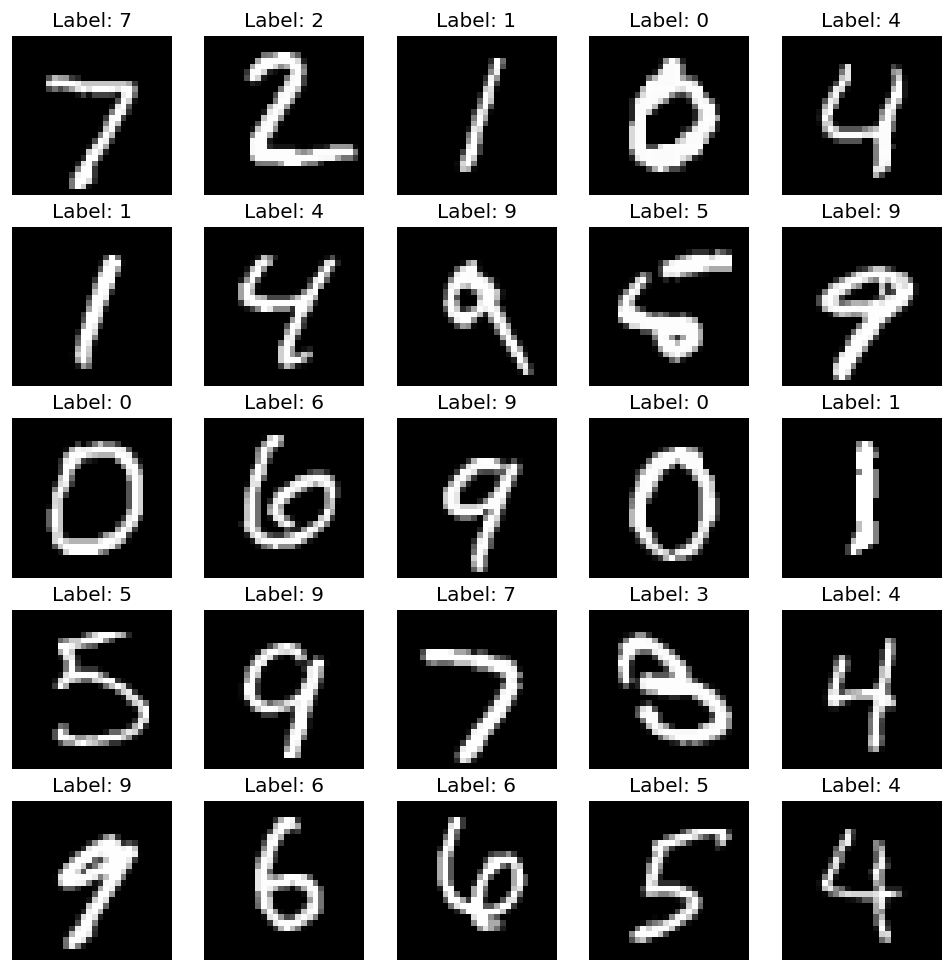

In [34]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10), dpi=120)
for i in range(25):
    image_tensor, label = mnist[i]
    ax[i // 5, i % 5].imshow(image_tensor.squeeze(), cmap="gray")
    ax[i // 5, i % 5].set_title(f"Label: {label}")
    ax[i // 5, i % 5].axis("off")
plt.show()

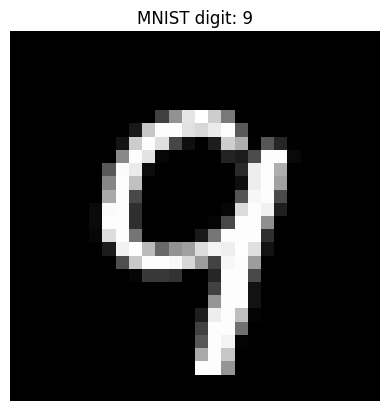

In [37]:
image_tensor, label = mnist[16]  # digit 9
plt.imshow(image_tensor.squeeze(), cmap="gray")
plt.title(f"MNIST digit: {label}")
plt.axis("off")
plt.show()